## 导入依赖

In [2]:
import numpy as np
import torch
import cv2
from matplotlib import pyplot as plt
import os
from ultralytics import YOLO

%matplotlib inline
# 设置精度
np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(precision=3, sci_mode=False)

## 载入模型

In [3]:
# 模型路径
# model_path = os.path.join(os.path.abspath("."), "weights", "color_block_yolov8seg.pt")
model_path = os.path.join(os.path.abspath("."), "weights", "marker_pen_yolov8n_seg.pt")
# 载入实例分割模型(使用绝对路径)
model = YOLO(model_path)

## 载入图像

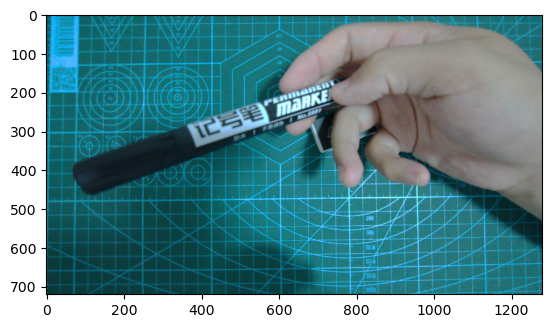

In [4]:
img = cv2.imread("data/marker_pen_01.png")
plt.imshow(img[:, :, ::-1])

## 模型预测

In [5]:
# 注意事项:
# - imgsz: 输入图像尺寸, 必须为32的倍数
# - conf: 置信度
# - iou: IOU阈值
results = model(img, imgsz=1088, conf=0.5, iou=0.6)
result = results[0] # 获取第一个结果
# result 


0: 640x1088 1 marker_pen, 30.4ms
Speed: 5.9ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1088, 1088)


## 物体矩形框

YoloV8 Seg也是包含目标检测部分的。查看目标检测的结果:

In [7]:
boxes_list = np.float64(result.boxes.data.tolist())
print(boxes_list)

[[ 70.938 163.716 764.082 459.939   0.952   0.   ]]


In [8]:
# 提取物体类别ID列表
class_id_list = np.uint8(boxes_list[:, 5])
print(f"物体ID列表: {class_id_list}")

物体ID列表: [0]


预测结果可视化

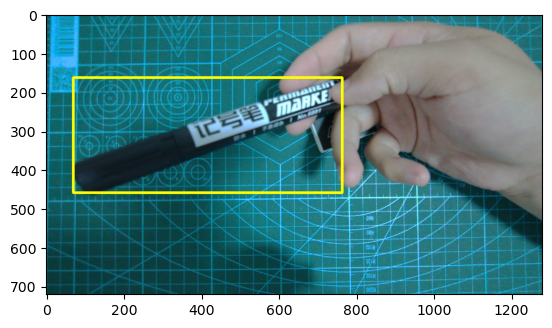

In [10]:
canvas = np.copy(img)
for box in boxes_list:
    x1, y1, x2, y2, conf, class_id = box
    pt1 = (int(x1), int(y1))
    pt2 = (int(x2), int(y2))
    color = (0, 255, 255)
    thickness = 5    
    canvas = cv2.rectangle(canvas, pt1, pt2, color, thickness)
plt.imshow(canvas[:, :, ::-1])

可以看到目标检测的精度很高。 

## 物体实例分割结果

In [11]:
# 获取掩码列表
obj_mask_list = np.uint8(result.masks.data.tolist()) * 255
# 提取obj_mask_list的尺寸
obj_num, mask_height, mask_width = obj_mask_list.shape
print(f"物体个数: {obj_num}")
print(f"掩码尺寸 宽度 {mask_width} 高度 {mask_height}")

物体个数: 1
掩码尺寸 宽度 1088 高度 640


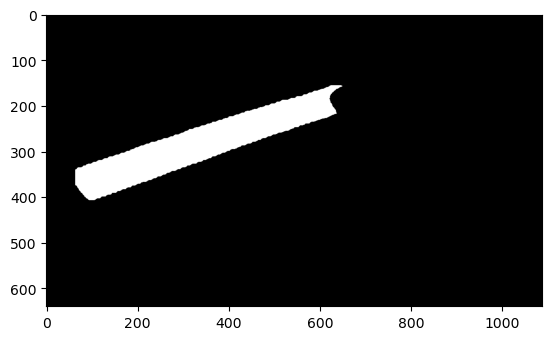

In [12]:
# 显示其中一个实例的Mask
obj_idx = 0
plt.imshow(obj_mask_list[obj_idx], cmap="gray")

重新调整mask尺寸，变成跟彩图尺寸一致

In [13]:
# 将Mask转换为彩图的尺寸
img_height, img_width = img.shape[:2]
obj_mask_list_resized = []
for mask in obj_mask_list:
    # 彩图分辨率 1280 * 720, 等比例缩放后是 1088 * 612
    # 传入模型的时候，会将尺寸填补到32的倍数 1088*640
    # 实际得到的Mask也是1088*640
    # 因此将Mask还原到原尺寸的时候，需要将Mask顶部还有底部去掉一部分再去等比例缩放
    mask_resize = cv2.resize(mask[14:-14,:], (img_width, img_height), interpolation=cv2.INTER_NEAREST)
    obj_mask_list_resized.append(mask_resize)

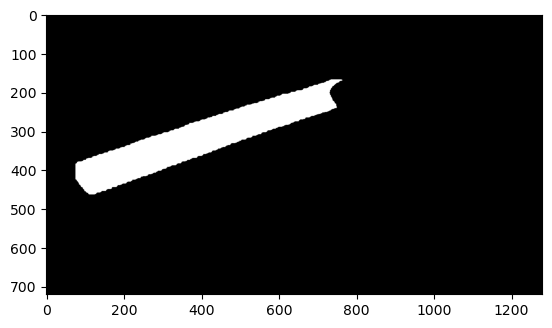

In [14]:
# 查看Resize后的Mask
obj_idx = 0
plt.imshow(obj_mask_list_resized[obj_idx], cmap="gray")

In [15]:
# 创建Mask掩码
mask_canvas = np.zeros((img_height, img_width, 3), dtype=np.uint8)
for mask in obj_mask_list_resized:
    mask_canvas[mask != 0] = [np.random.randint(255) for i in range(3)]

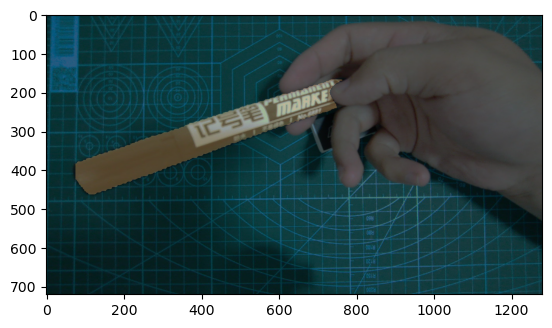

In [16]:
# 彩图与Mask画布叠加
canvas = cv2.addWeighted(img, 0.5, mask_canvas, 0.5, 0.2)
plt.imshow(canvas[:, :, ::-1])

In [13]:
# Mask的多边形轮廓(归一化坐标)
# result.masks.segments